In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import utils.dsp
import utils.phantom
import utils.opt
from recon.TV_FISTA import tvdeblur

# get device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA unavailable - using CPU")
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA version: 12.1
Number of GPUs: 4


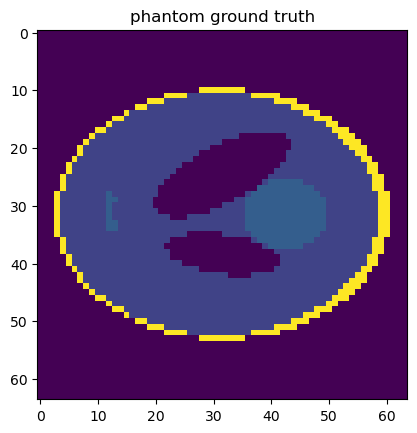

In [2]:
# generate phantom
N = 64
p = utils.phantom.phantom3d((N,N,1)).squeeze().to(device)
plt.figure(0)
plt.imshow(np.absolute(p.cpu().numpy()))
plt.title('phantom ground truth')
plt.show()

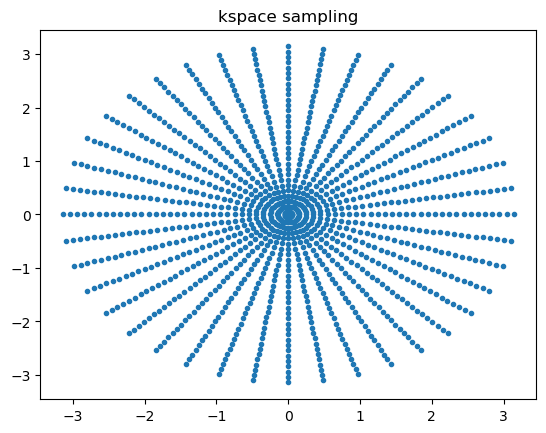

In [3]:
# generate radial kspace trajectory
kspoke = np.stack((np.linspace(-np.pi,np.pi,N),np.zeros((N))),axis=0)
nspokes = 20 # fully sampled in-plane is pi*N

for i in range(0,nspokes):
    theta = np.pi*i/nspokes
    R = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    kspokei = np.matmul(R,kspoke)
    if i == 0:
        klocs = kspokei
    else:
        klocs = np.concatenate((klocs,kspokei),axis=1)

plt.figure(0)
plt.plot(klocs[0,:],klocs[1,:],'.')
plt.title('kspace sampling')
plt.show()

klocs = torch.tensor(klocs).to(device)

/home/djfrey/tvrec/utils/phantom.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(smaps,dtype=torch.complex128)


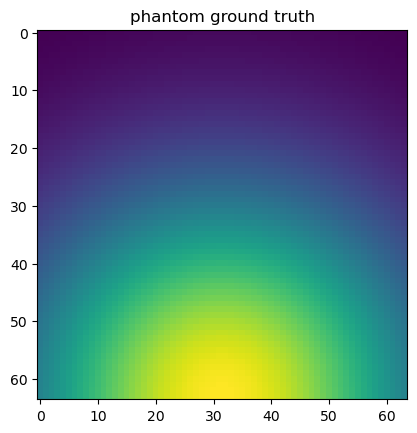

In [4]:
# create the nufft object and define fwd/adj operators
nufft_ob = tkbn.KbNufft(im_size=(N,N),device=device)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=(N,N),device=device)

smaps = utils.phantom.simsmaps((N,N,1)).squeeze().to(device)

def A_fwd(x):
    return nufft_ob(x.unsqueeze(0).unsqueeze(0),klocs,smaps=smaps.unsqueeze(0))
def A_adj(b):
    return adjnufft_ob(b,klocs,smaps=smaps.unsqueeze(0)).clone().squeeze()

# show a sense map
plt.figure(0)
plt.imshow(np.absolute(smaps[1,:,:].squeeze().cpu().numpy()))
plt.title('SENSE map (coil 1)')
plt.show()

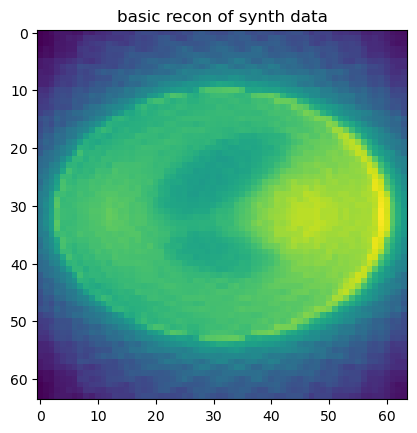

In [22]:
# synthesize kspace data and show basic recon
kdata = A_fwd(p)

plt.figure(0)
plt.imshow(np.absolute(A_adj(kdata).cpu().numpy()))
plt.title('basic recon of synth data')
plt.show()

In [9]:
# estimate the Lipschitz constant using power iteration
L = utils.opt.pwritr(A_fwd,A_adj,p)
print(L)

tensor(12588.8872, device='cuda:0', dtype=torch.float64)


TV_FISTA.tvdeblur(): iter 0, cost = 76528585779509.578125
TV_FISTA.tvdeblur(): iter 1, cost = 315443195727.291199
TV_FISTA.tvdeblur(): iter 2, cost = 146809636151.540009
TV_FISTA.tvdeblur(): iter 3, cost = 66208202348.378654
TV_FISTA.tvdeblur(): iter 4, cost = 31302322279.114223
TV_FISTA.tvdeblur(): iter 5, cost = 16205948663.941849
TV_FISTA.tvdeblur(): iter 6, cost = 8925822660.328587
TV_FISTA.tvdeblur(): iter 7, cost = 4976334706.102962
TV_FISTA.tvdeblur(): iter 8, cost = 2824795351.009641
TV_FISTA.tvdeblur(): iter 9, cost = 1725208428.347809
TV_FISTA.tvdeblur(): iter 10, cost = 1150345119.727082
TV_FISTA.tvdeblur(): iter 11, cost = 786124784.705769
TV_FISTA.tvdeblur(): iter 12, cost = 514887704.077688
TV_FISTA.tvdeblur(): iter 13, cost = 318419654.120367
TV_FISTA.tvdeblur(): iter 14, cost = 194703977.850187
TV_FISTA.tvdeblur(): iter 15, cost = 129183675.207653
TV_FISTA.tvdeblur(): iter 16, cost = 99829515.131324
TV_FISTA.tvdeblur(): iter 17, cost = 87629320.325573
TV_FISTA.tvdeblur(

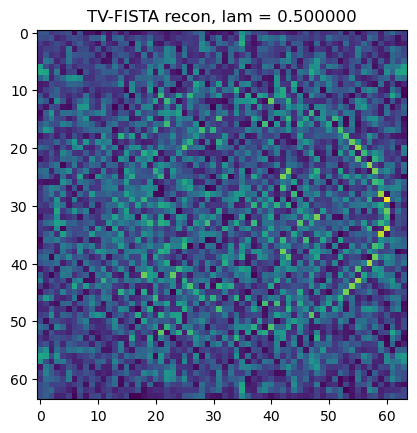

In [16]:
# recon the image
lam = 0.5
niter = 300
x_star, cost, x_set = tvdeblur(A_fwd, A_adj, kdata, lam=lam, niter=niter, L=L, chat=0)

plt.figure(0)
plt.imshow(np.absolute(x_star.cpu().numpy()))
plt.title('TV-FISTA recon, lam = %f' % lam)
plt.show()

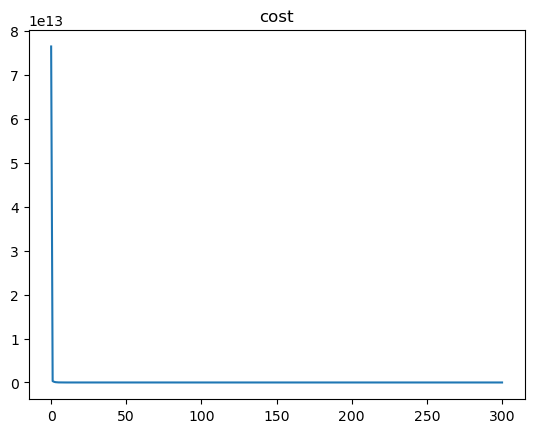

In [17]:
# analyze if you want to
plt.figure(0)
plt.plot([c.cpu().numpy() for c in cost])
plt.title('cost')
plt.show()